## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

This architecture in `models.py` is taken from [this paper](https://arxiv.org/pdf/1710.00977.pdf)


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [3]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [4]:
##Importing the model
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import Net

net = Net()
net.load_state_dict(torch.load('./saved_models/keypoints_model_best.pt'))
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.5)
  (dropout6): Dropout(p=0.6)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### Define a data transform

1. Rescaling and cropping the data, such that you are left with a square image (224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

In [5]:
import torch
from torchvision import transforms, utils
import random
import PIL
from PIL import Image
# tranforms

class Normalize(object):
    """Convert a color image to grayscale and normalize the color range to [0,1]."""        

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # convert image to grayscale
        image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # scale color range from [0, 255] to [0, 1]
        image_copy=  image_copy/255.0
        
        # scale keypoints to be centered around 0 with a range of [-1, 1]
        # mean = 100, sqrt = 50, so, pts should be (pts - 100)/50
        #key_pts_copy = (key_pts_copy/image_copy.shape[1]*2 - 1)
        key_pts_copy = (key_pts_copy-100)/50


        return {'image': image_copy, 'keypoints': key_pts_copy}


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = cv2.resize(image, (new_w, new_h))
        
        # scale the pts, too
        key_pts = key_pts * [new_w / w, new_h / h]

        return {'image': img, 'keypoints': key_pts}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        key_pts = key_pts - [left, top]

        return {'image': image, 'keypoints': key_pts}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, key_pts = sample['image'], sample['keypoints']
         
        # if image has no grayscale color channel, add one
        if(len(image.shape) == 2):
            # add that third color dim
            image = image.reshape(image.shape[0], image.shape[1], 1)
            
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(key_pts)}

    
    
##NOT USED
class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            new_keypoints = abs(sample['keypoints']-np.array([sample['image'].shape[1],0]))
            new_image = PIL.Image.fromarray(sample['image'])
            new_image = np.array(new_image.transpose(Image.FLIP_LEFT_RIGHT))
            return {'image': new_image,
                'keypoints': new_keypoints}
        return {'image': sample['image'],
                'keypoints': sample['keypoints']}
    
class RandomVerticalFlip(object):
    """Vertically flip the given PIL Image randomly with a given probability.

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p
        

    def __call__(self, sample):
        """
        Args:
            img (PIL Image): Image to be flipped.

        Returns:
            PIL Image: Randomly flipped image.
        """
        if random.random() < self.p:
            new_keypoints = abs(sample['keypoints']-np.array([0,sample['image'].shape[1]]))
            new_image = PIL.Image.fromarray(sample['image'])
            new_image = np.array(new_image.transpose(Image.FLIP_TOP_BOTTOM))
            return {'image': new_image,
                'keypoints': new_keypoints}
        return {'image': sample['image'],
                'keypoints': sample['keypoints']}
    
    


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                    ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [21]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')

Length of dataset:  3462


C:\Users\Enrico\OneDrive - Università di Cagliari\Documenti\GitHub\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([1, 224, 224])


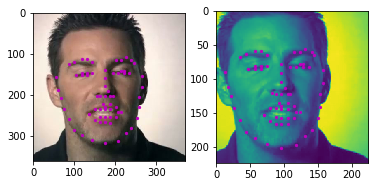

In [7]:
# Construct the dataset
face_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/')

# print some stats about the dataset
print('Length of dataset: ', len(face_dataset))
##Try the transform
test_num = 1000
example = face_dataset[test_num]
fig = plt.figure()
ax = plt.subplot(1, 2, 1)
transformed_sample = data_transform(example)
print(transformed_sample['image'].shape)
show_keypoints(example['image'], example['keypoints'])
ax = plt.subplot(1, 2,  2)
#print(transformed_sample['keypoints'])
show_keypoints(transformed_sample['image'][0,:,:], transformed_sample['keypoints']*50+100)

plt.show()

In [8]:
print(transformed_sample['keypoints'])

tensor([[-1.7380, -0.2133],
        [-1.6549,  0.2311],
        [-1.5718,  0.4950],
        [-1.4748,  0.8561],
        [-1.3085,  1.2172],
        [-1.1284,  1.5644],
        [-0.8652,  1.7450],
        [-0.5050,  1.9256],
        [-0.0755,  2.0228],
        [ 0.3679,  1.9394],
        [ 0.6311,  1.6894],
        [ 0.8112,  1.5089],
        [ 0.9913,  1.1617],
        [ 1.0744,  0.8144],
        [ 1.0744,  0.4533],
        [ 1.1576,  0.1061],
        [ 1.1576, -0.2550],
        [-1.3085, -0.6439],
        [-1.1284, -0.7272],
        [-0.8652, -0.8106],
        [-0.6851, -0.8106],
        [-0.5050, -0.7133],
        [ 0.2847, -0.7967],
        [ 0.4649, -0.7967],
        [ 0.6311, -0.8800],
        [ 0.8112, -0.7828],
        [ 0.8943, -0.6994],
        [-0.0755, -0.4494],
        [-0.0755, -0.1856],
        [-0.0755,  0.0783],
        [ 0.0215,  0.2589],
        [-0.3387,  0.4256],
        [-0.2417,  0.4394],
        [-0.0755,  0.4394],
        [ 0.1046,  0.4394],
        [ 0.1878,  0

In [11]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462


C:\Users\Enrico\OneDrive - Università di Cagliari\Documenti\GitHub\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data
#### Loading the training dataset

In [16]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


## Before training

#### Loading the test dataset

In [17]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

test_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                      root_dir='data/training/',
                                             transform=transforms.Compose([Rescale(250),
                                                                           RandomCrop(224),
                                                                           Normalize(),
                                                                           ToTensor()]))



In [18]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Applying the model on a test sample

1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Converting the image to a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

In [19]:
# test the model on a batch of test images

def net_sample_output(mode='test'):
    if mode=='test':
        loader = test_loader
    elif mode=='train': 
        loader = train_loader
                
    # iterate through the test dataset
    for i, sample in enumerate(loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

## Visualize the predicted keypoints

In [22]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

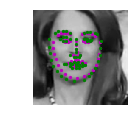

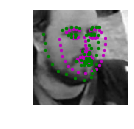

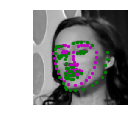

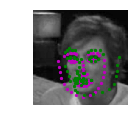

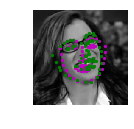

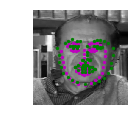

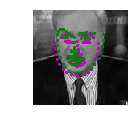

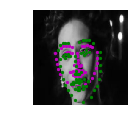

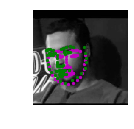

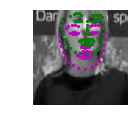

In [23]:
test_images, test_outputs, gt_pts = net_sample_output('train')

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = (predicted_key_pts*50)+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Examples of loss functions (like MSE or L1/SmoothL1 loss) [here](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

---

In [16]:
##Train with GPU
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, dtype=None, non_blocking=True,copy=True)
    
dev = get_default_device()
print(dev)

cuda


In [17]:
## TODO: Define the loss and optimization
import torch.optim as optim

## TODO: specify loss function for regression
criterion = nn.MSELoss() #SmoothL1Loss
#criterion = criterion.to(dev)

## TODO: specify optimizer 
optimizer = optim.Adam(net.parameters(), lr=0.001) ##SGD


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [9]:
# prepare the net for training (initialize weights)
net.train()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.5)
  (dropout6): Dropout(p=0.6)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)

In [10]:
def train_net(n_epochs):
    net.to(dev)

    # prepare the net for training
    net.train()
    
    loss_over_time = [] # to track the loss as the network trains

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            #print(batch_i)
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)
            
            # move labels and images to GPU
            key_pts = key_pts.to(dev)
            images = images.to(dev)
            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            
            if batch_i % 10 == 9:    # print every 10 batches
                
                avg_loss = running_loss/10
                # record and print the avg loss over the 10 batches
                loss_over_time.append(avg_loss)
                
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time

In [20]:
# train your network
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
if 'training_loss' in locals():
    training_loss = np.hstack((training_loss, np.array((train_net(n_epochs)))))
else:
    training_loss = train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.3851290106773376
Epoch: 1, Batch: 20, Avg. Loss: 0.18510799631476402
Epoch: 1, Batch: 30, Avg. Loss: 0.20185788571834565
Epoch: 1, Batch: 40, Avg. Loss: 0.15994624570012092
Epoch: 1, Batch: 50, Avg. Loss: 0.19614335745573044
Epoch: 1, Batch: 60, Avg. Loss: 0.3161954402923584
Epoch: 1, Batch: 70, Avg. Loss: 0.14410357773303986
Epoch: 1, Batch: 80, Avg. Loss: 0.29092825949192047
Epoch: 1, Batch: 90, Avg. Loss: 0.19501570463180543
Epoch: 1, Batch: 100, Avg. Loss: 0.24380685314536094
Epoch: 1, Batch: 110, Avg. Loss: 0.18444225564599037
Epoch: 1, Batch: 120, Avg. Loss: 0.17550405710935593
Epoch: 1, Batch: 130, Avg. Loss: 0.1989383652806282
Epoch: 1, Batch: 140, Avg. Loss: 0.18542298600077628
Epoch: 1, Batch: 150, Avg. Loss: 0.21284777000546456
Epoch: 1, Batch: 160, Avg. Loss: 0.1594196304678917
Epoch: 1, Batch: 170, Avg. Loss: 0.1965394750237465
Epoch: 1, Batch: 180, Avg. Loss: 0.18957652971148492
Epoch: 1, Batch: 190, Avg. Loss: 0.21486240550875663
Epoch: 

Epoch: 10, Batch: 60, Avg. Loss: 0.04192238133400679
Epoch: 10, Batch: 70, Avg. Loss: 0.03679852243512869
Epoch: 10, Batch: 80, Avg. Loss: 0.03385150544345379
Epoch: 10, Batch: 90, Avg. Loss: 0.048708639666438104
Epoch: 10, Batch: 100, Avg. Loss: 0.04197876919060946
Epoch: 10, Batch: 110, Avg. Loss: 0.04075661823153496
Epoch: 10, Batch: 120, Avg. Loss: 0.039506448246538636
Epoch: 10, Batch: 130, Avg. Loss: 0.038331431522965434
Epoch: 10, Batch: 140, Avg. Loss: 0.03802988324314356
Epoch: 10, Batch: 150, Avg. Loss: 0.050059360824525355
Epoch: 10, Batch: 160, Avg. Loss: 0.060983611084520814
Epoch: 10, Batch: 170, Avg. Loss: 0.04150678925216198
Epoch: 10, Batch: 180, Avg. Loss: 0.22474119793623687
Epoch: 10, Batch: 190, Avg. Loss: 0.06216642186045647
Epoch: 10, Batch: 200, Avg. Loss: 0.0556353697553277
Epoch: 10, Batch: 210, Avg. Loss: 0.03369237687438727
Epoch: 10, Batch: 220, Avg. Loss: 0.026221893541514874
Epoch: 10, Batch: 230, Avg. Loss: 0.04197159111499786
Epoch: 10, Batch: 240, Avg.

Epoch: 14, Batch: 220, Avg. Loss: 0.03139122426509857
Epoch: 14, Batch: 230, Avg. Loss: 0.025262641720473766
Epoch: 14, Batch: 240, Avg. Loss: 0.03658787040039897
Epoch: 14, Batch: 250, Avg. Loss: 0.0324667040258646
Epoch: 14, Batch: 260, Avg. Loss: 0.030544067919254302
Epoch: 14, Batch: 270, Avg. Loss: 0.05596438432112336
Epoch: 14, Batch: 280, Avg. Loss: 0.033992855809628963
Epoch: 14, Batch: 290, Avg. Loss: 0.030839346535503864
Epoch: 14, Batch: 300, Avg. Loss: 0.03541188072413206
Epoch: 14, Batch: 310, Avg. Loss: 0.02829002309590578
Epoch: 14, Batch: 320, Avg. Loss: 0.023115495592355727
Epoch: 14, Batch: 330, Avg. Loss: 0.024807128682732583
Epoch: 14, Batch: 340, Avg. Loss: 0.023999012261629104
Epoch: 15, Batch: 10, Avg. Loss: 0.0415106687694788
Epoch: 15, Batch: 20, Avg. Loss: 0.03302448708564043
Epoch: 15, Batch: 30, Avg. Loss: 0.03928219024091959
Epoch: 15, Batch: 40, Avg. Loss: 0.02794296629726887
Epoch: 15, Batch: 50, Avg. Loss: 0.03181550372391939
Epoch: 15, Batch: 60, Avg. L

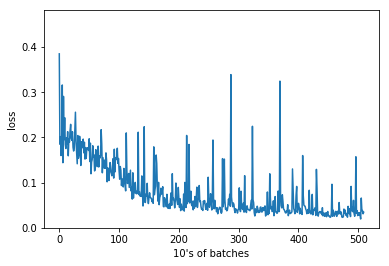

In [21]:
training_loss = np.array(training_loss)
# visualize the loss as the network trained
plt.plot(training_loss)
plt.xlabel('10\'s of batches')
plt.ylabel('loss')
plt.ylim(0, max(training_loss)*1.25) # relative scale
plt.show()

## Test data

Checking if the model generalized with respect to the training set (best practice is to use cross-validation to check this during training)

In [22]:
net.to('cpu')
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output('test')

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


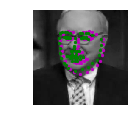

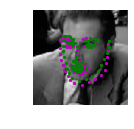

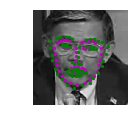

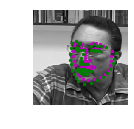

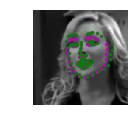

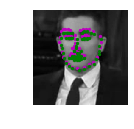

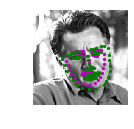

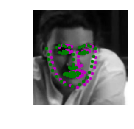

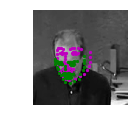

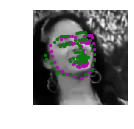

In [25]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


In [26]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_chetto_224_new.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

[[-0.04288825 -0.22219335  0.13077202 -0.01792073  0.14984168]
 [ 0.08437099 -0.02373671 -0.07203342  0.0445059  -0.06477546]
 [ 0.1326792   0.10527276 -0.02140393 -0.23106737 -0.13907492]
 [-0.11344741 -0.10050415 -0.00956522  0.11674895 -0.23786493]
 [-0.08295811  0.06334125  0.01524666  0.14967853  0.03660847]]
(5, 5)


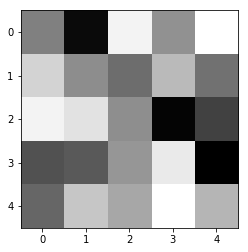

In [29]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps
Visualizing the weights of the convolutional layer allows to understand better what the CNN is using to classify the images

0
(10, 1, 224, 224)
(224, 224)
(224, 224)


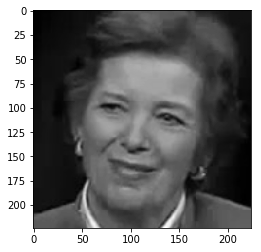

In [24]:
import cv2

def get_test_image():

    for i, sample in enumerate(test_loader):
        
        print(i)    
        images = sample['image']
        images = images.numpy()
        print(images.shape)
    
        plt.imshow(np.squeeze(images[0]), cmap='gray')
        print(np.squeeze(images[0]).shape)
        
        # break after first image is tested
        if i == 0:
            return np.squeeze(images[0])
        
image = get_test_image()   
print(image.shape)


[[-0.00366724 -0.0880565   0.01706944  0.07626427 -0.17795984]
 [ 0.00408524 -0.28667268 -0.17698598 -0.21354279 -0.10766631]
 [-0.05566109 -0.03300377 -0.17584248 -0.2653025   0.02716499]
 [-0.18847731  0.02025431 -0.06661785  0.13109483 -0.15514445]
 [ 0.09550903 -0.04537069  0.07316843  0.10494675 -0.23094954]]
(5, 5)


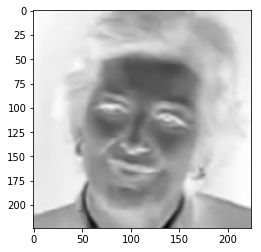

In [25]:
# Get the weights in the first conv layer, "conv1"
# The first layer is usually more standard and detects edges, blurs images etc.
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 6

print(w[filter_index][0])
print(w[filter_index][0].shape)
filtered_image = cv2.filter2D(image, -1, w[filter_index][0])

# display the filter weights
plt.imshow(filtered_image, cmap='gray')

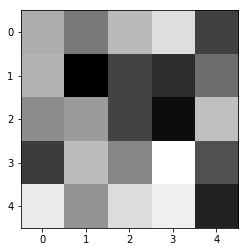

In [26]:
plt.imshow(w[filter_index][0], cmap='gray')

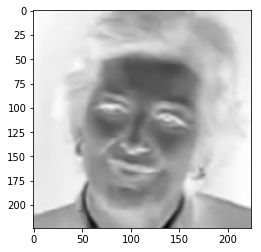

In [27]:
## applying filter to the test image

img_filt = cv2.filter2D(image, -1, w[filter_index][0])

plt.imshow(img_filt, cmap='gray')